# Reference data preparation

In [1]:
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Read in the count matrix into an [AnnData](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html) object, which holds many slots for annotations and different representations of the data. It also comes with its own HDF5-based file format: `.h5ad`.

In [2]:
sc_adata = sc.read_10x_mtx(
    '../datasets/sinclecell/wu/BrCa_Atlas_Count_out',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

In [3]:
sc_df = sc_adata.to_df()

In [4]:
# xen_df = pd.read_table("../data/xenium_preview_rep1/nucleus_singlecell.txt")
# xen_df.dropna(axis=1, how='all', inplace=True) # Remove columns of all NaN
# xen_df.dropna(inplace=True) # Drop rows containing NaN

In [5]:
# xen_df = xen_df[['Object ID']+xen_df.columns[pd.Series(xen_df.columns).str.startswith('xenium:cell_transcript:')].tolist()]
# xen_df.set_index("Object ID", inplace = True)
# xen_df.columns = [t.replace('xenium:cell_transcript:','') for t in xen_df.columns.tolist()]

In [6]:
# ref_df = sc_df[sc_df.columns.intersection(xen_df.columns)]
ref_df = sc_df

In [7]:
ref_adata = ad.AnnData(csr_matrix(ref_df.values), dtype=np.float32)
ref_adata.obs_names = ref_df.index
ref_adata.var_names = ref_df.columns
ref_adata.obs.index = ref_adata.obs.index.astype(str)
ref_adata.var_names_make_unique()

In [8]:
# sc.pp.calculate_qc_metrics(ref_adata, percent_top=(50, 100, 200, 300), inplace=True)

In [9]:
# ref_adata

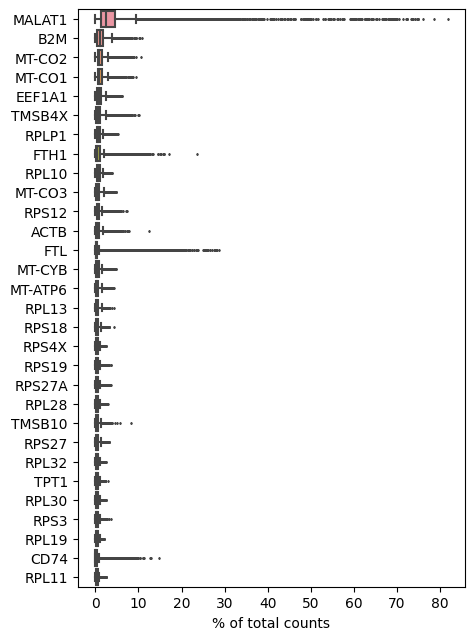

In [10]:
sc.pl.highest_expr_genes(ref_adata, n_top=30)

Basic filtering:

In [11]:
sc.pp.filter_cells(ref_adata, min_genes=100)
sc.pp.filter_genes(ref_adata, min_cells=1000)
sc.pp.filter_cells(ref_adata, max_counts=50000)

Let’s assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.
With pp.calculate_qc_metrics, we can compute many metrics very efficiently.

In [12]:
ref_adata.var['mt'] = ref_adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(ref_adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

A violin plot of some of the computed quality measures:

the number of genes expressed in the count matrix
the total counts per cell
the percentage of counts in mitochondrial genes

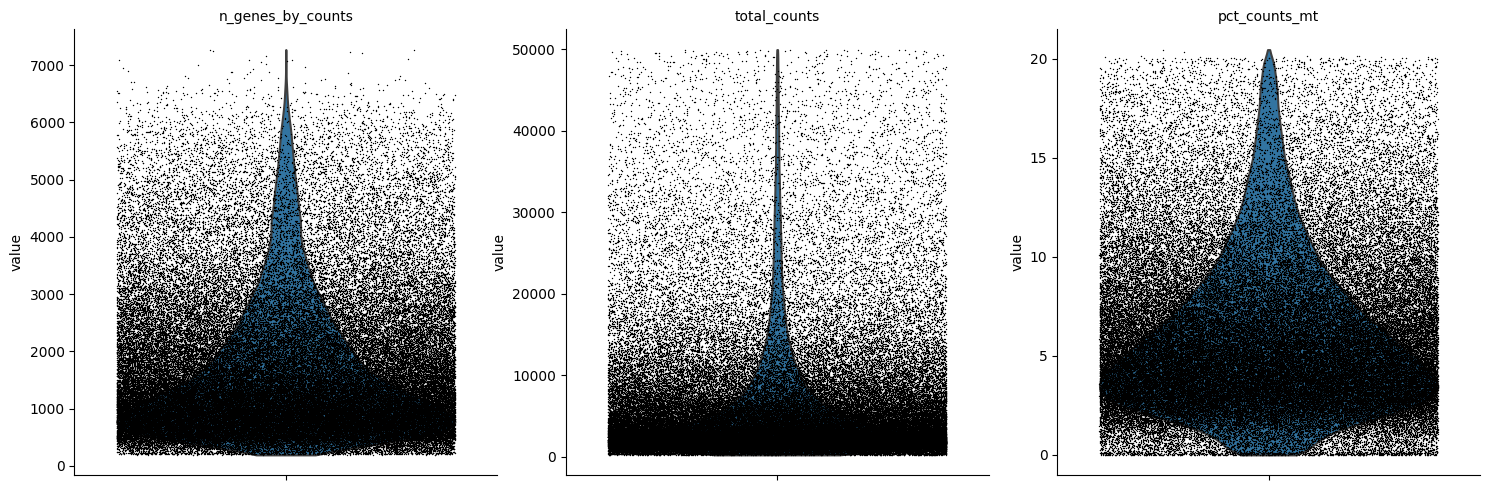

In [13]:
sc.pl.violin(ref_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

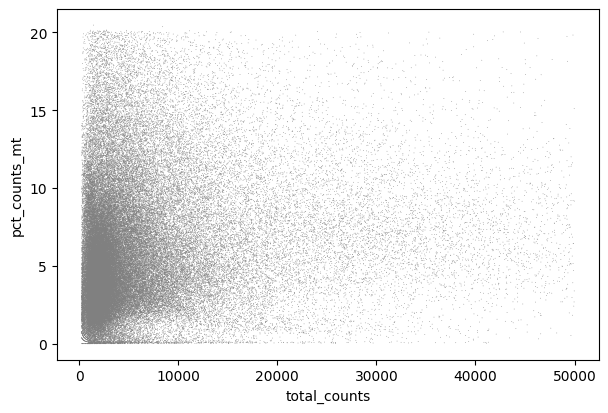

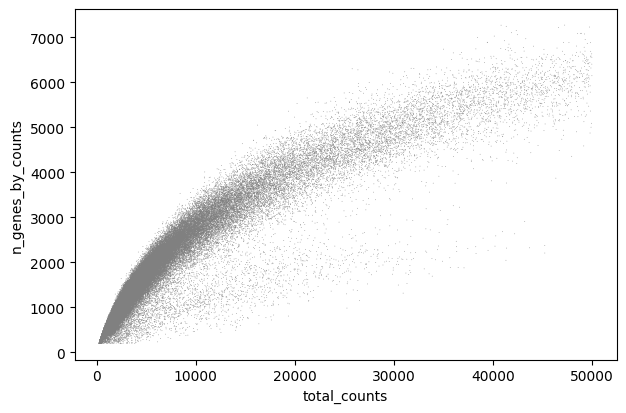

In [14]:
sc.pl.scatter(ref_adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(ref_adata, x='total_counts', y='n_genes_by_counts')

In [15]:
ref_adata = ref_adata[ref_adata.obs.n_genes_by_counts < 75000, :]
ref_adata = ref_adata[ref_adata.obs.pct_counts_mt < 20, :]

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

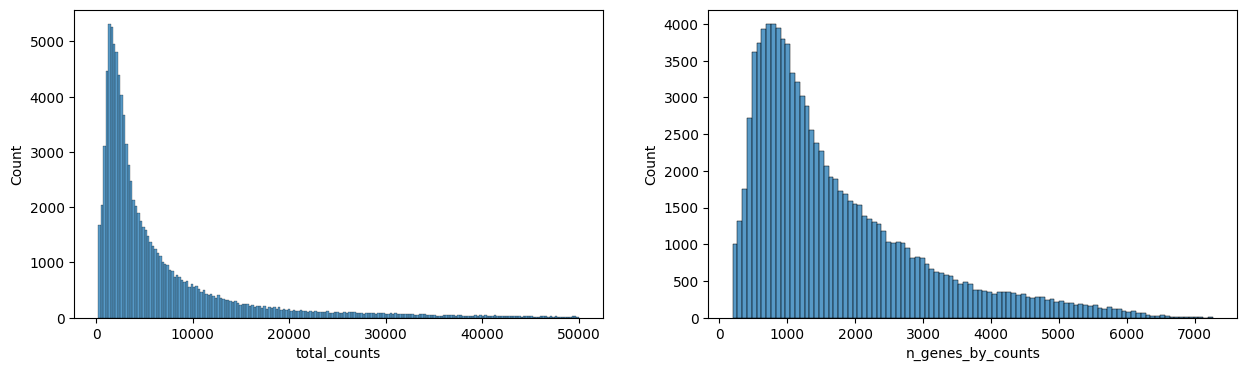

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(
    ref_adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)
sns.histplot(
    ref_adata.obs["n_genes_by_counts"],
    kde=False,
    bins=100,
    ax=axs[1],
)

In [17]:
sc.pp.filter_cells(ref_adata, max_counts=75000)
# sc.pp.filter_cells(ref_adata, min_genes=3)
# sc.pp.filter_genes(ref_adata, min_cells=100)

/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [18]:
# sc.pl.violin(
#         ref_adata,
#         ["n_genes_by_counts", "total_counts"],
#         jitter=0.4,
#         multi_panel=True,
#     )

In [19]:
# # define outliers and do the filtering for the 3k dataset
# ref_adata.obs['outlier_total'] = ref_adata.obs.total_counts > 2000
# ref_adata.obs['outlier_ngenes'] = ref_adata.obs.n_genes_by_counts > 150

# print('%u cells with large total counts' % (sum(ref_adata.obs['outlier_total'])))
# print('%u cells with large number of genes' % (sum(ref_adata.obs['outlier_ngenes'])))

# ref_adata = ref_adata[~ref_adata.obs['outlier_total'], :]
# ref_adata = ref_adata[~ref_adata.obs['outlier_ngenes'], :]

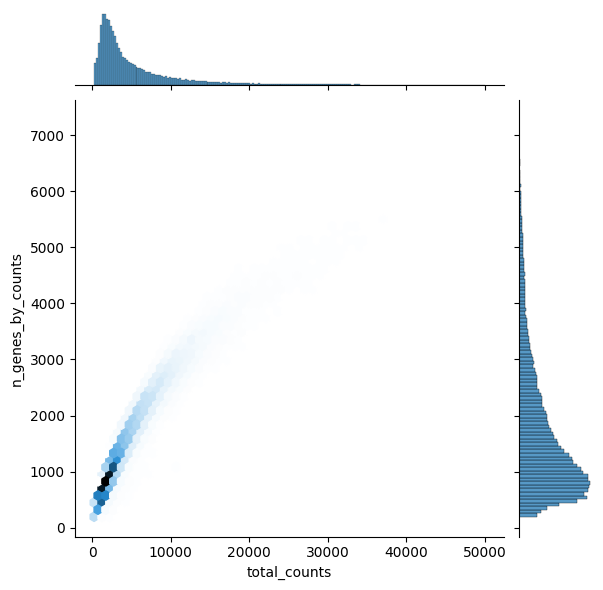

In [20]:
# sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
# sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
#
## Or, a better plot
#
sns.jointplot(
    data=ref_adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

In [21]:
ref_adata.layers["counts"] = ref_adata.X.copy()
sc.pp.normalize_total(ref_adata, inplace=True)

In [22]:
ref_adata.to_df().sum(axis=1)

CID3586_AAGACCTCAGCATGAG    3507.000000
CID3586_AAGGTTCGTAGTACCT    3507.000000
CID3586_ACCAGTAGTTGTGGCC    3507.000000
CID3586_ACCCACTAGATGTCGG    3507.000000
CID3586_ACTGATGGTCAACTGT    3507.000244
                               ...     
CID4398_TCAGGTAGTACTCAAC    3507.000000
CID4398_TCTATTGTCGCCATAA    3507.000244
CID4398_TCTTTCCCAGTAAGCG    3507.000000
CID4398_TGCCCATGTTACGGAG    3507.000000
CID4398_TTGAACGTCCTATTCA    3507.000244
Length: 99074, dtype: float32

In [23]:
sc.pp.log1p(ref_adata)

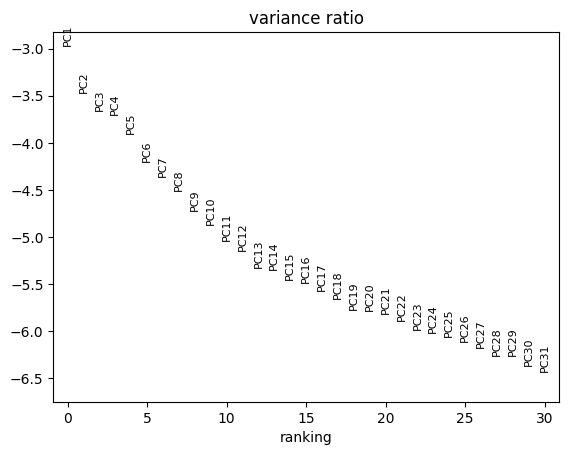

In [24]:
sc.pp.pca(ref_adata)
sc.pl.pca_variance_ratio(ref_adata, log=True)

In [25]:
sc.pp.neighbors(ref_adata)
sc.tl.umap(ref_adata)
sc.tl.leiden(ref_adata, key_added="subtype", resolution = 0.05)

In [37]:
ref_adata.obs

,n_genes,n_counts,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,subtype
CID3586_AAGACCTCAGCATGAG,1689,4559.0,1668,7.419980,4559.0,8.425077,69.0,4.248495,1.513490,3
CID3586_AAGGTTCGTAGTACCT,779,1717.0,770,6.647688,1717.0,7.448916,100.0,4.615120,5.824112,3
CID3586_ACCAGTAGTTGTGGCC,514,1218.0,504,6.224558,1218.0,7.105786,17.0,2.890372,1.395731,3
CID3586_ACCCACTAGATGTCGG,609,1344.0,601,6.400257,1344.0,7.204149,26.0,3.295837,1.934524,3
CID3586_ACTGATGGTCAACTGT,807,1701.0,798,6.683361,1701.0,7.439559,228.0,5.433722,13.403881,3
...,...,...,...,...,...,...,...,...,...,...
CID4398_TCAGGTAGTACTCAAC,1251,6178.0,1241,7.124478,6178.0,8.728911,167.0,5.123964,2.703140,9
CID4398_TCTATTGTCGCCATAA,719,4603.0,713,6.570883,4603.0,8.434681,141.0,4.955827,3.063220,9
CID4398_TCTTTCCCAGTAAGCG,887,2977.0,878,6.778785,2977.0,7.999007,110.0,4.709530,3.694995,9
CID4398_TGCCCATGTTACGGAG,870,5104.0,858,6.755769,5104.0,8.537975,113.0,4.736198,2.213950,9


/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


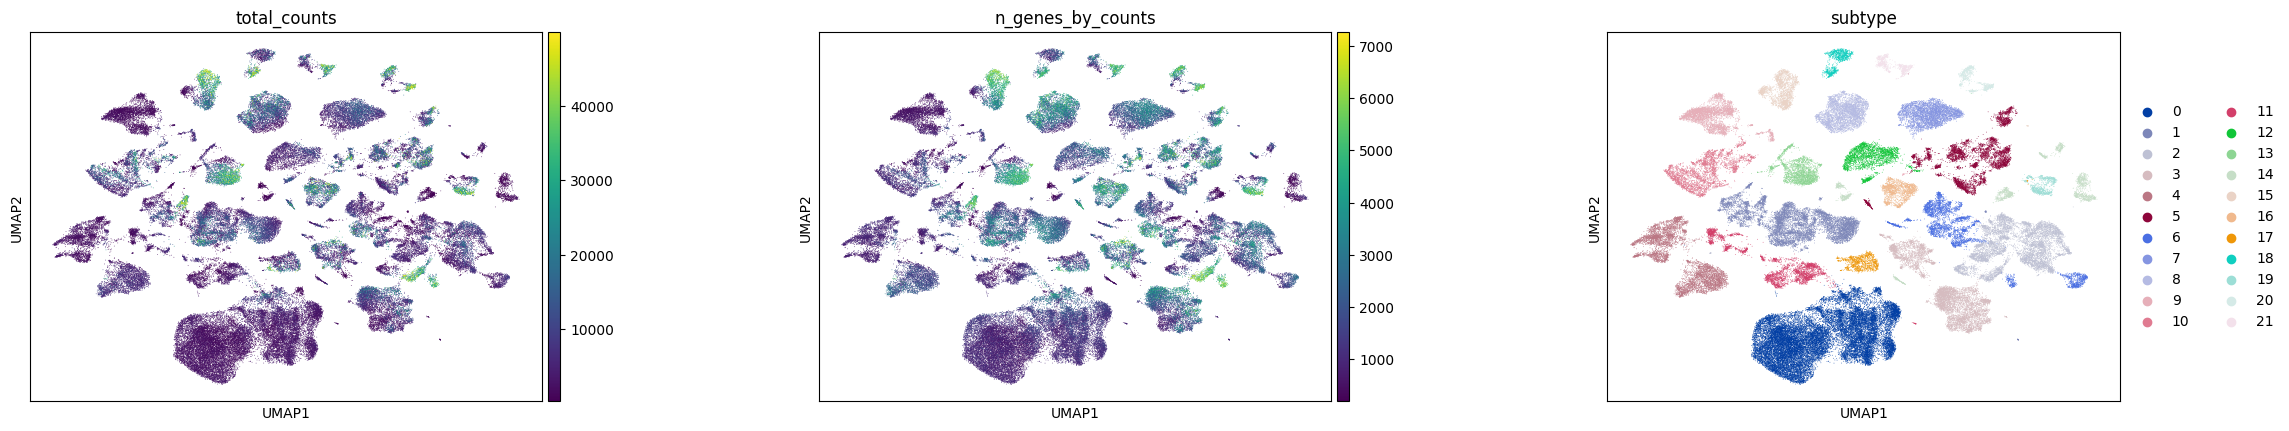

In [26]:
sc.pl.umap(
    ref_adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "subtype",
    ],
    wspace=0.4,
)

/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is high

categories: 0, 1, 2, etc.
var_group_labels: 0, 1, 2


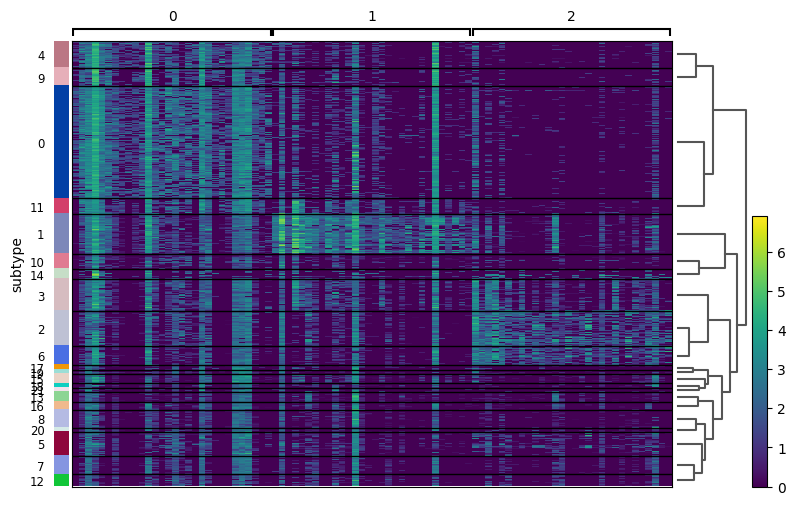

In [27]:
sc.tl.dendrogram(ref_adata, groupby='subtype')
sc.tl.rank_genes_groups(ref_adata, "subtype", method="t-test")
sc.pl.rank_genes_groups_heatmap(ref_adata, groups="012", n_genes=30, groupby="subtype")

/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:399: PerformanceWarning: DataFrame is high

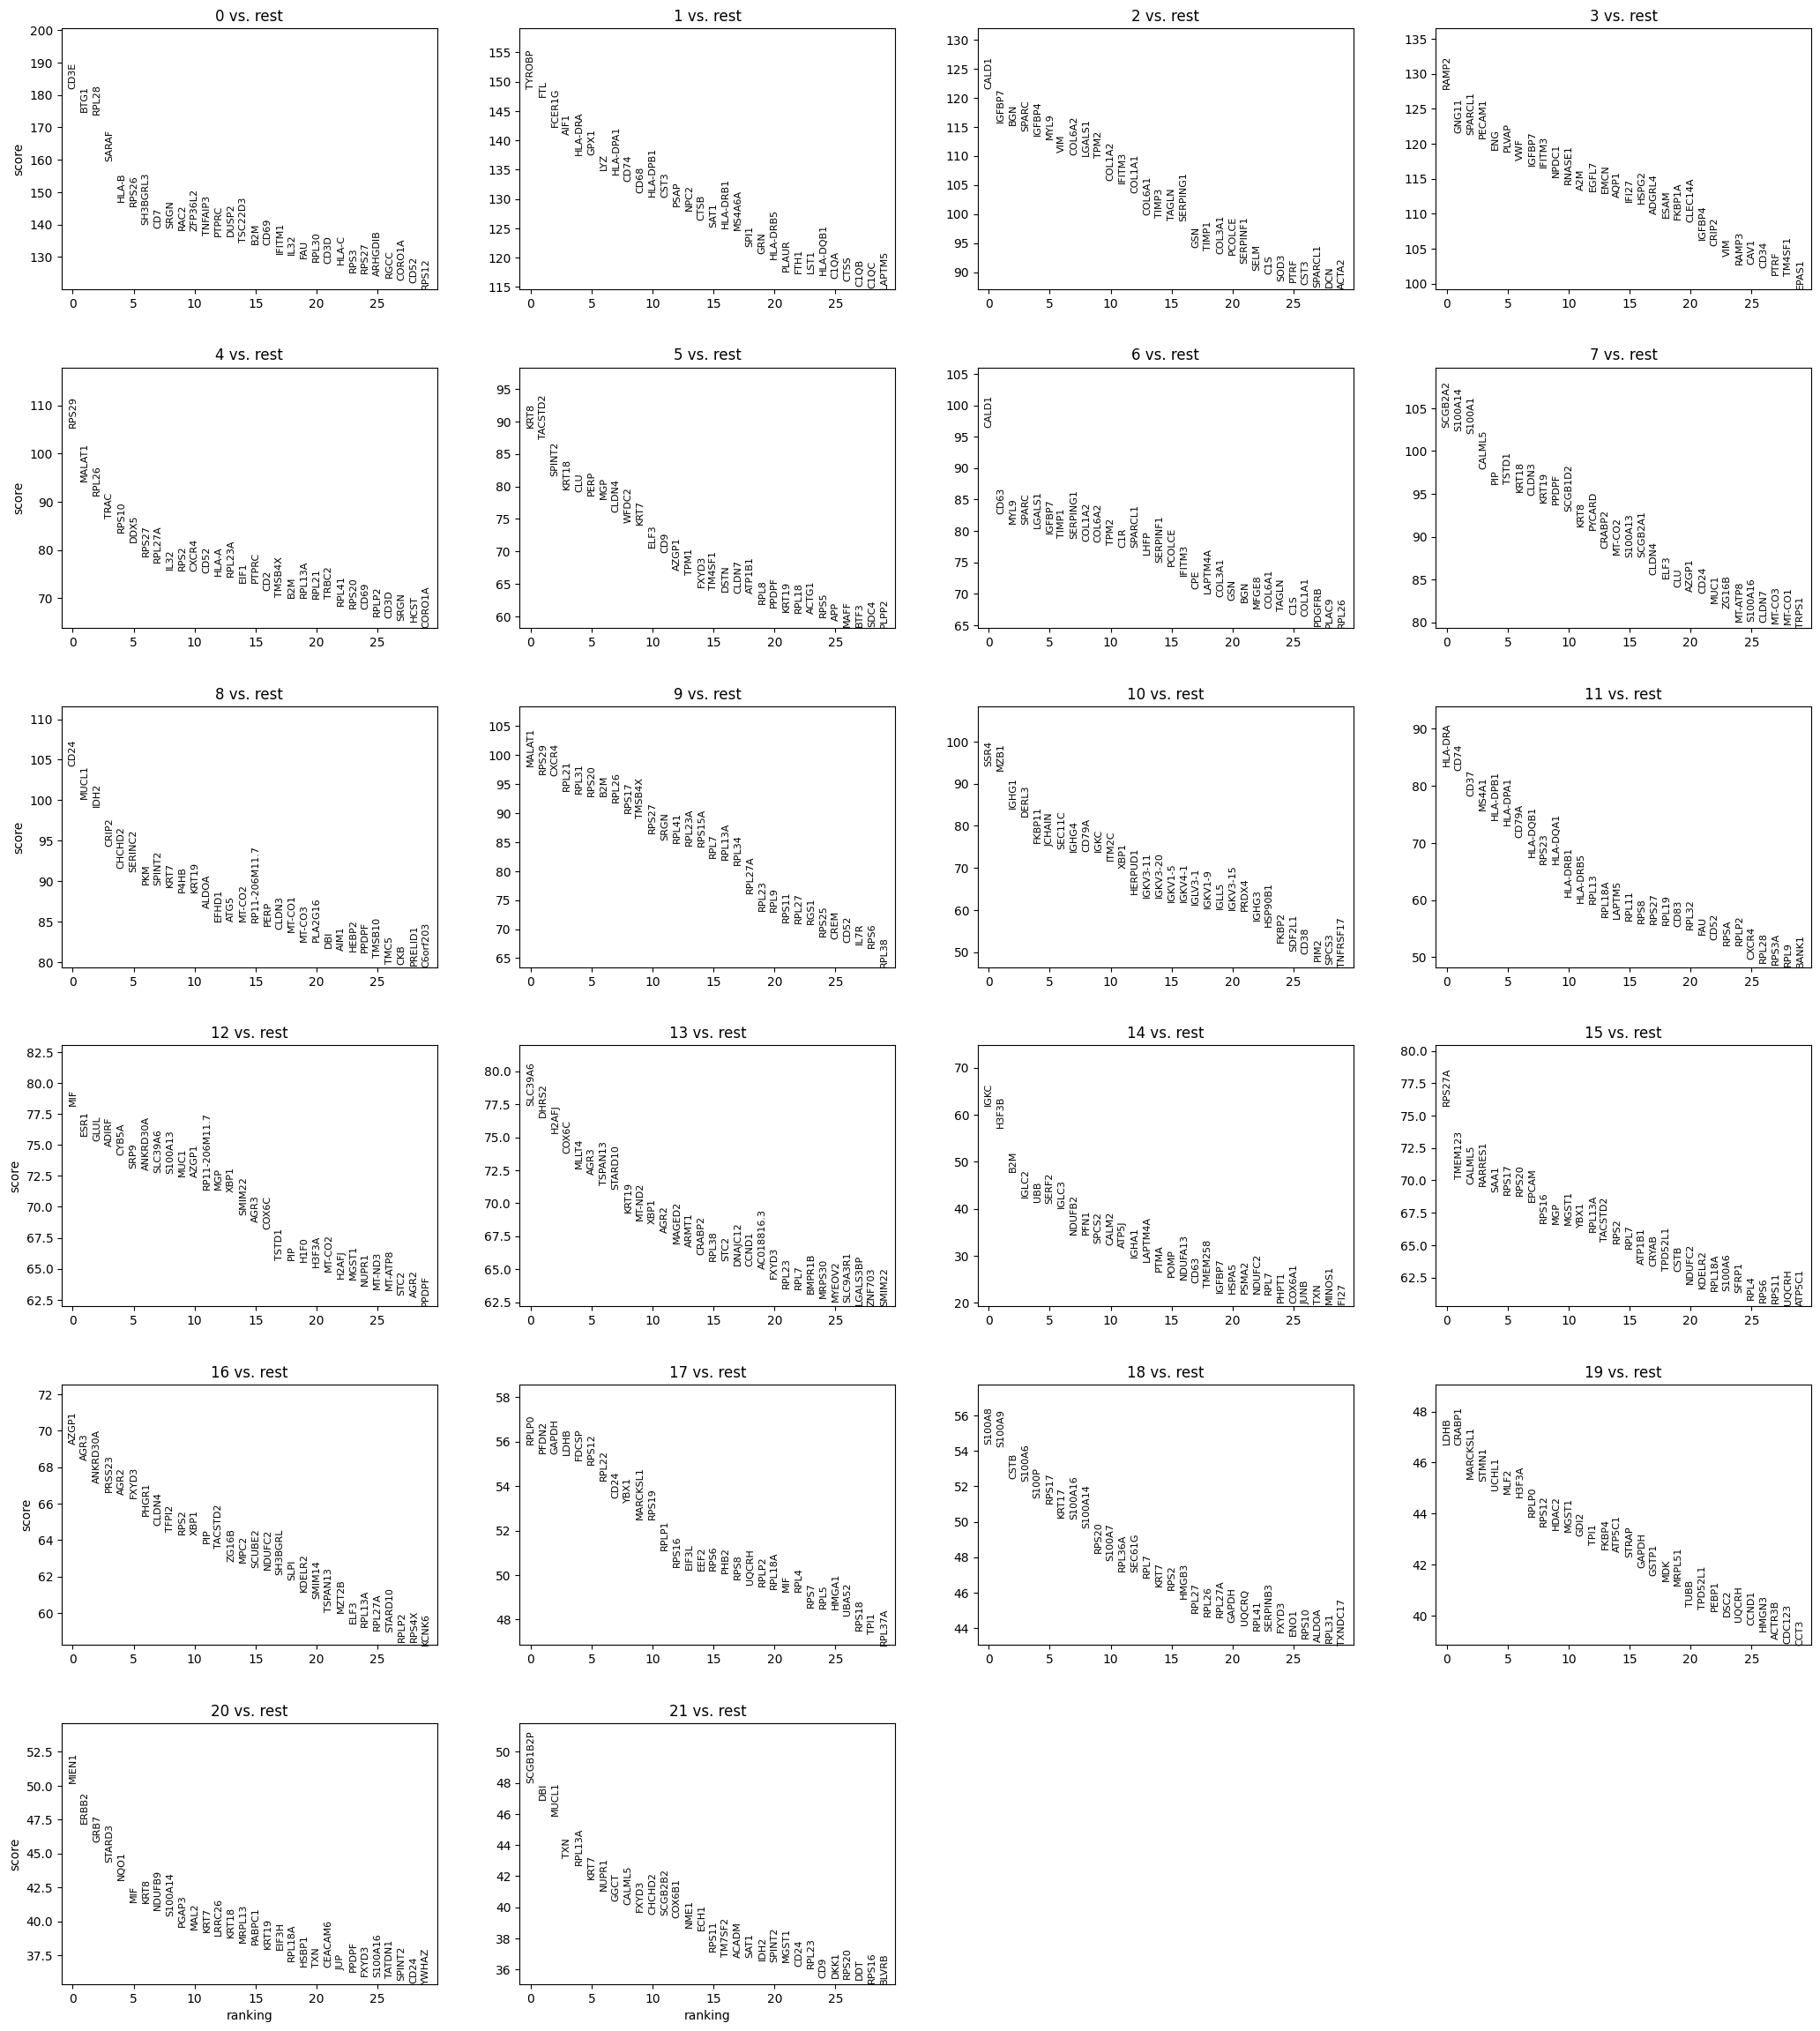

In [28]:
sc.tl.rank_genes_groups(ref_adata, 'subtype', method='wilcoxon')
sc.pl.rank_genes_groups(ref_adata, n_genes=30, sharey=False)

In [29]:
top_gene_num = 2

In [30]:
top_gene_list = pd.DataFrame(ref_adata.uns['rank_genes_groups']['names']).head(top_gene_num)
top_gene_list

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,CD3E,TYROBP,CALD1,RAMP2,RPS29,KRT8,CALD1,SCGB2A2,CD24,MALAT1,...,MIF,SLC39A6,IGKC,RPS27A,AZGP1,RPLP0,S100A8,LDHB,MIEN1,SCGB1B2P
1,BTG1,FTL,IGFBP7,GNG11,MALAT1,TACSTD2,CD63,S100A14,MUCL1,RPS29,...,ESR1,DHRS2,H3F3B,TMEM123,AGR3,PFDN2,S100A9,CRABP1,ERBB2,DBI


In [31]:
marker_genes = list(set(np.array(top_gene_list).reshape(-1)))
len(marker_genes)

41

/opt/anaconda3/envs/sptx2/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


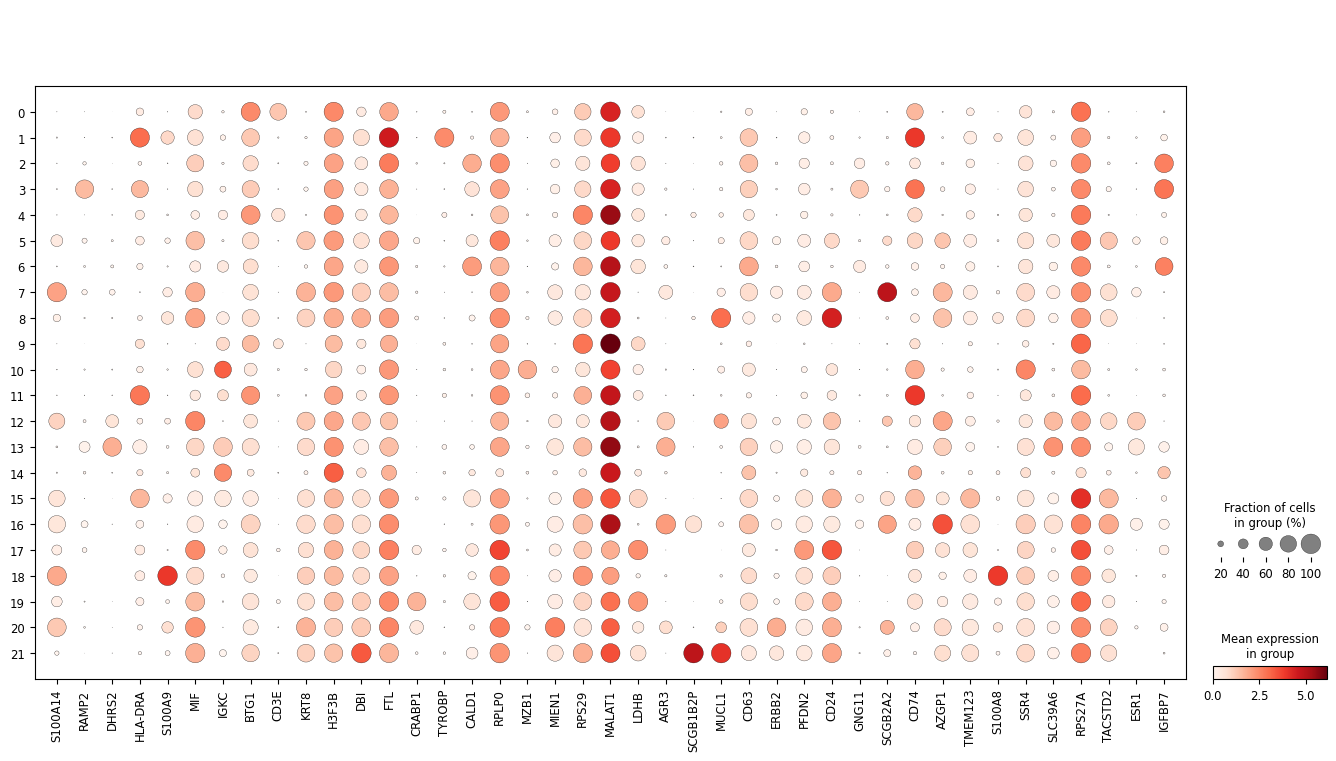

In [31]:
sc.pl.dotplot(ref_adata, marker_genes, groupby='subtype');

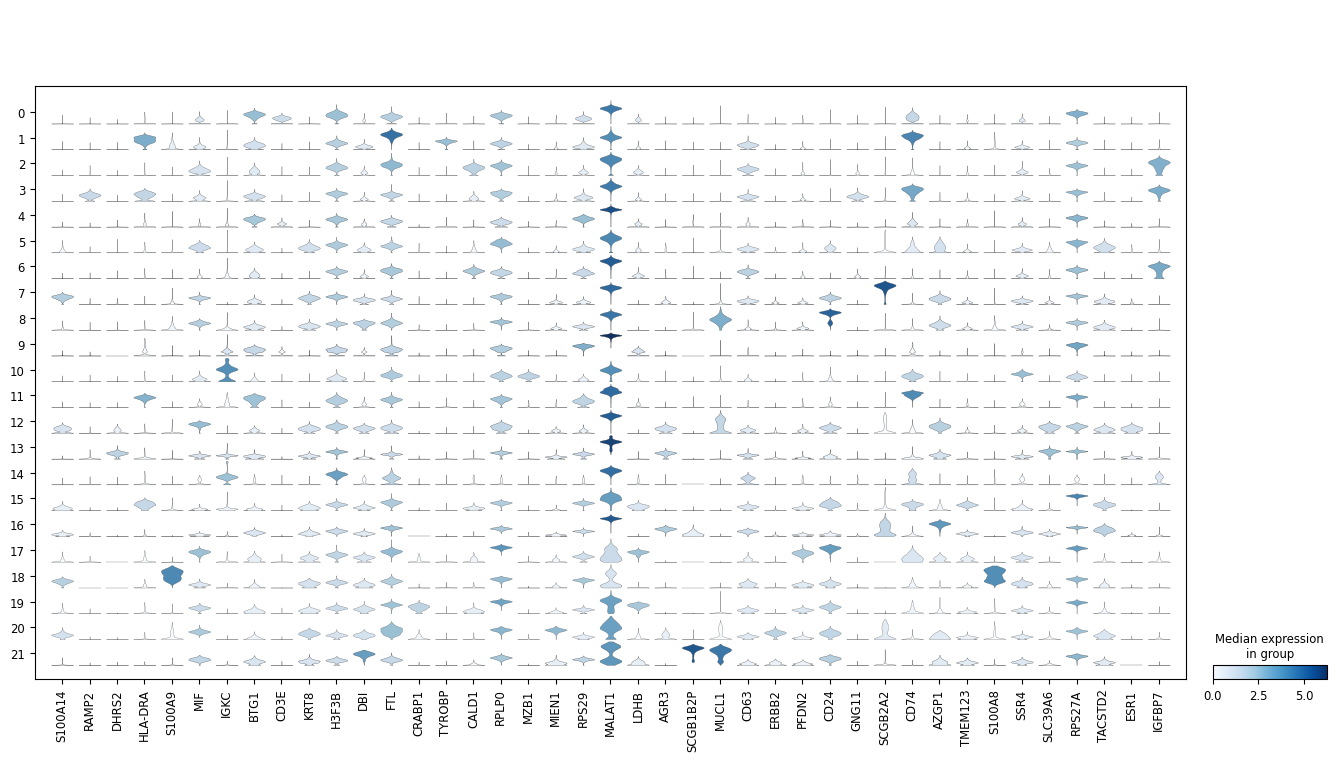

In [32]:
sc.pl.stacked_violin(ref_adata, marker_genes, groupby='subtype', rotation=90);

In [39]:
sub_result_df = result_df.sample(10000)

In [33]:
result_df = ref_adata.to_df()
result_df.insert(0, "subtype", ref_adata.obs['subtype'])

In [47]:
result_df.to_csv("../data/xenium_preview_rep1/reference_singlecell_normalized.csv")

In [41]:
# result_df.to_hdf("../data/xenium_preview_rep1/reference_singlecell_normalized.h5", "ref", format='table')

HDF5ExtError: HDF5 error back trace

  File "H5A.c", line 298, in H5Acreate2
    unable to create attribute
  File "H5VLcallback.c", line 988, in H5VL_attr_create
    attribute create failed
  File "H5VLcallback.c", line 955, in H5VL__attr_create
    attribute create failed
  File "H5VLnative_attr.c", line 75, in H5VL__native_attr_create
    unable to create attribute
  File "H5Aint.c", line 268, in H5A__create
    unable to create attribute in object header
  File "H5Oattribute.c", line 317, in H5O__attr_create
    unable to create new attribute in header
  File "H5Omessage.c", line 205, in H5O__msg_append_real
    unable to create new message
  File "H5Omessage.c", line 1847, in H5O__msg_alloc
    unable to allocate space for message
  File "H5Oalloc.c", line 1291, in H5O__alloc
    object header message is too large

End of HDF5 error back trace

Can't set attribute 'non_index_axes' in node:
 /ref (Group) ''.

In [42]:
ref_adata.write_h5ad("../data/xenium_preview_rep1/reference_singlecell_normalized.h5ad",compression='gzip')

In [43]:
ref2_adata = sc.read_h5ad("../data/xenium_preview_rep1/reference_singlecell_normalized.h5ad")

In [44]:
result2_df = ref2_adata.to_df()

In [46]:
result2_df.shape

(99074, 14189)